In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
from utils import imshow, show_plot
from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
from tqdm import tqdm
import config

In [2]:
# load the dataset
training_dir = config.training_dir
testing_dir = config.testing_dir
training_csv = config.training_csv
testing_csv = config.testing_csv
val_csv = config.val_csv
val_dir = config.val_dir

In [3]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):
        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)

In [4]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataset = SiameseDataset(
    testing_csv,
    testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

eval_dataset = SiameseDataset(
    val_csv,
    val_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

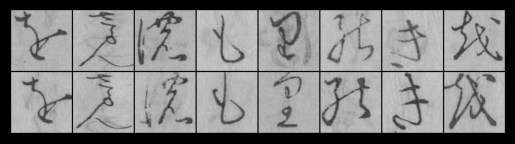

[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [5]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class SiameseNetwork(nn.Module):
    """
    Siamese network for image similarity estimation.
    The network is composed of two identical networks, one for each input.
    The output of each network is concatenated and passed to a linear layer.
    The output of the linear layer passed through a sigmoid function.
    `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
    This implementation varies from FaceNet as we use the `ResNet-18` model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
    In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        self.fc_in_features = self.resnet.fc.in_features

        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features
        output = torch.cat((output1, output2), 1)

        # pass the concatenation to the linear layers
        output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output = self.sigmoid(output)

        return output

In [8]:
# train the model
def train(model, device, optimizer, train_dataloader, train_losses, t_correct_set):
    criterion = nn.BCELoss()
    model.train()
    train_loss = 0
    correct = 0

    for _, (images_1, images_2, targets) in enumerate(train_dataloader, 0):
        images_1, images_2, targets = (
            images_1.to(device),
            images_2.to(device),
            targets.to(device),
        )
        optimizer.zero_grad()
        outputs = model(images_1, images_2)
        loss = criterion(outputs, targets)
        train_loss += loss
        loss.backward()
        optimizer.step()
        pred = torch.where(
            outputs > 0.5, 1, 0
        )  # get the index of the max log-probability
        correct += pred.eq(targets.view_as(pred)).sum().item()

    train_loss /= len(train_dataloader.dataset)
    print(
        "\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            train_loss,
            correct,
            len(train_dataloader.dataset),
            100.0 * correct / len(train_dataloader.dataset),
        )
    )
    train_losses.append(train_loss.cpu().detach().numpy())
    t_correct_set.append(correct / len(train_dataloader.dataset))
    return train_loss


def eval(model, device, eval_dataloader, val_losses, v_correct_set):
    criterion = nn.BCELoss()
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images_1, images_2, targets in eval_dataloader:
            images_1, images_2, targets = (
                images_1.to(device),
                images_2.to(device),
                targets.to(device),
            )
            outputs = model(images_1, images_2)
            val_loss += criterion(outputs, targets).sum().item()
            pred = torch.where(
                outputs > 0.5, 1, 0
            )  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()

    val_loss /= len(eval_dataloader.dataset)

    print(
        "\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            val_loss,
            correct,
            len(eval_dataloader.dataset),
            100.0 * correct / len(eval_dataloader.dataset),
        )
    )
    val_losses.append(val_loss)
    v_correct_set.append(correct / len(eval_dataloader.dataset))

    return val_loss

In [9]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(
    siamese_dataset, shuffle=True, batch_size=config.batch_size
)
eval_dataloader = DataLoader(eval_dataset, shuffle=True, batch_size=config.batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=config.batch_size)

# Declare Siamese Network
model = SiameseNetwork().to(device)
# Decalre Loss Function
criterion = nn.BCELoss()
# Declare Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)
val_losses = []
train_losses = []
t_correct_set = []
v_correct_set = []
best_eval_loss = 999
# eval(model, device, eval_dataloader)
for epoch in tqdm(range(1, config.epochs)):
    train_loss = train(
        model, device, optimizer, train_dataloader, train_losses, t_correct_set
    )
    val_loss = eval(model, device, eval_dataloader, val_losses, v_correct_set)

    print("-" * 20)

    if val_loss < best_eval_loss:
        best_eval_loss = val_loss
        print(f"Best Eval loss: {best_eval_loss}")
        torch.save(model.state_dict(), "content/model_BCE.pth")
        print("Model Saved Successfully")
        print("-" * 20)

  0%|          | 0/19 [00:00<?, ?it/s]


Train set: Average loss: 0.0095, Accuracy: 7886/9064 (87%)


  5%|▌         | 1/19 [00:27<08:08, 27.13s/it]


Val set: Average loss: 0.0072, Accuracy: 2044/2266 (90%)
--------------------
Best Eval loss: 0.00720244549734342
Model Saved Successfully
--------------------

Train set: Average loss: 0.0079, Accuracy: 8077/9064 (89%)


 11%|█         | 2/19 [00:52<07:27, 26.34s/it]


Val set: Average loss: 0.0075, Accuracy: 2031/2266 (90%)
--------------------

Train set: Average loss: 0.0072, Accuracy: 8200/9064 (90%)


 16%|█▌        | 3/19 [01:20<07:07, 26.71s/it]


Val set: Average loss: 0.0076, Accuracy: 2025/2266 (89%)
--------------------

Train set: Average loss: 0.0069, Accuracy: 8197/9064 (90%)


 21%|██        | 4/19 [01:47<06:42, 26.84s/it]


Val set: Average loss: 0.0079, Accuracy: 2026/2266 (89%)
--------------------

Train set: Average loss: 0.0072, Accuracy: 8181/9064 (90%)


 26%|██▋       | 5/19 [02:14<06:18, 27.07s/it]


Val set: Average loss: 0.0062, Accuracy: 2097/2266 (93%)
--------------------
Best Eval loss: 0.006160198816896432
Model Saved Successfully
--------------------

Train set: Average loss: 0.0070, Accuracy: 8249/9064 (91%)


 32%|███▏      | 6/19 [02:41<05:52, 27.13s/it]


Val set: Average loss: 0.0110, Accuracy: 1945/2266 (86%)
--------------------

Train set: Average loss: 0.0069, Accuracy: 8244/9064 (91%)


 37%|███▋      | 7/19 [03:08<05:22, 26.84s/it]


Val set: Average loss: 0.0076, Accuracy: 2039/2266 (90%)
--------------------

Train set: Average loss: 0.0065, Accuracy: 8329/9064 (92%)


 42%|████▏     | 8/19 [03:34<04:55, 26.84s/it]


Val set: Average loss: 0.0072, Accuracy: 2044/2266 (90%)
--------------------

Train set: Average loss: 0.0063, Accuracy: 8322/9064 (92%)


 47%|████▋     | 9/19 [04:01<04:27, 26.76s/it]


Val set: Average loss: 0.0057, Accuracy: 2096/2266 (92%)
--------------------
Best Eval loss: 0.005718416998792515
Model Saved Successfully
--------------------

Train set: Average loss: 0.0062, Accuracy: 8320/9064 (92%)


 53%|█████▎    | 10/19 [04:28<04:01, 26.83s/it]


Val set: Average loss: 0.0056, Accuracy: 2099/2266 (93%)
--------------------
Best Eval loss: 0.005637090718940834
Model Saved Successfully
--------------------

Train set: Average loss: 0.0059, Accuracy: 8391/9064 (93%)


 58%|█████▊    | 11/19 [04:54<03:33, 26.73s/it]


Val set: Average loss: 0.0062, Accuracy: 2085/2266 (92%)
--------------------

Train set: Average loss: 0.0058, Accuracy: 8401/9064 (93%)


 63%|██████▎   | 12/19 [05:21<03:06, 26.63s/it]


Val set: Average loss: 0.0065, Accuracy: 2073/2266 (91%)
--------------------

Train set: Average loss: 0.0054, Accuracy: 8468/9064 (93%)


 68%|██████▊   | 13/19 [05:47<02:39, 26.61s/it]


Val set: Average loss: 0.0053, Accuracy: 2096/2266 (92%)
--------------------
Best Eval loss: 0.00531857975800534
Model Saved Successfully
--------------------

Train set: Average loss: 0.0052, Accuracy: 8482/9064 (94%)


 74%|███████▎  | 14/19 [06:15<02:15, 27.04s/it]


Val set: Average loss: 0.0047, Accuracy: 2128/2266 (94%)
--------------------
Best Eval loss: 0.0047053257356885255
Model Saved Successfully
--------------------

Train set: Average loss: 0.0050, Accuracy: 8509/9064 (94%)


 79%|███████▉  | 15/19 [06:43<01:49, 27.29s/it]


Val set: Average loss: 0.0047, Accuracy: 2144/2266 (95%)
--------------------
Best Eval loss: 0.004668737811818127
Model Saved Successfully
--------------------

Train set: Average loss: 0.0048, Accuracy: 8516/9064 (94%)


 84%|████████▍ | 16/19 [07:10<01:21, 27.17s/it]


Val set: Average loss: 0.0084, Accuracy: 2043/2266 (90%)
--------------------

Train set: Average loss: 0.0043, Accuracy: 8598/9064 (95%)


 89%|████████▉ | 17/19 [07:37<00:53, 26.96s/it]


Val set: Average loss: 0.0043, Accuracy: 2147/2266 (95%)
--------------------
Best Eval loss: 0.004344177110957447
Model Saved Successfully
--------------------

Train set: Average loss: 0.0044, Accuracy: 8583/9064 (95%)


 95%|█████████▍| 18/19 [08:06<00:27, 27.61s/it]


Val set: Average loss: 0.0040, Accuracy: 2151/2266 (95%)
--------------------
Best Eval loss: 0.004033294009884847
Model Saved Successfully
--------------------

Train set: Average loss: 0.0040, Accuracy: 8628/9064 (95%)


100%|██████████| 19/19 [08:33<00:00, 27.03s/it]


Val set: Average loss: 0.0034, Accuracy: 2185/2266 (96%)
--------------------
Best Eval loss: 0.0033858706114282674
Model Saved Successfully
--------------------


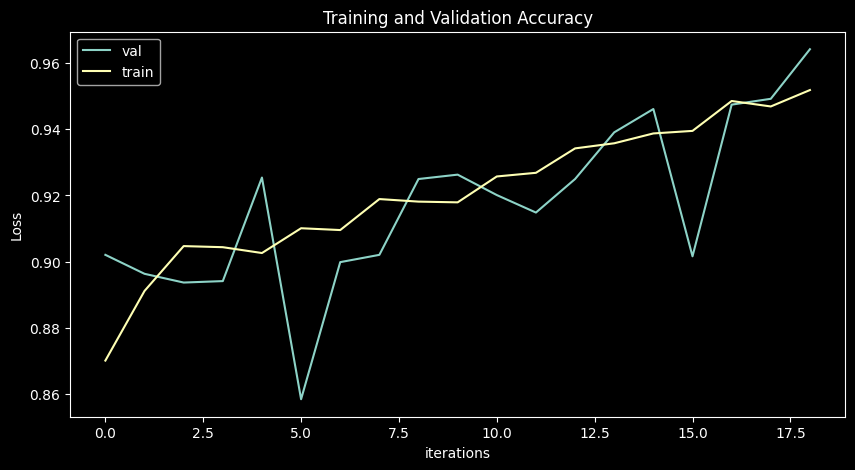

In [19]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(v_correct_set, label="val")
plt.plot(t_correct_set, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

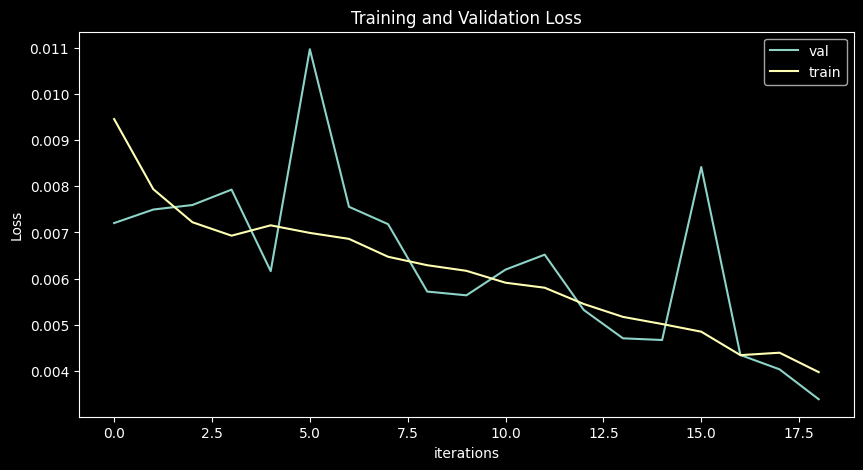

In [20]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for images_1, images_2, targets in test_dataloader:
        images_1, images_2, targets = (
            images_1.to(device),
            images_2.to(device),
            targets.to(device),
        )
        outputs = model(images_1, images_2)
        test_loss += criterion(outputs, targets).sum().item()  # sum up batch loss
        pred = torch.where(
            outputs > 0.5, 1, 0
        )  # get the index of the max log-probability
        correct += pred.eq(targets.view_as(pred)).sum().item()
print(
    "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss / len(test_dataloader.dataset),
        correct,
        len(test_dataloader.dataset),
        100.0 * correct / len(test_dataloader.dataset),
    )
)


Test set: Average loss: 0.0205, Accuracy: 2141/2267 (94%)



In [23]:
# Viewing the sample of images and to check whether its loading properly
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=8)
dataiter = iter(test_dataloader)

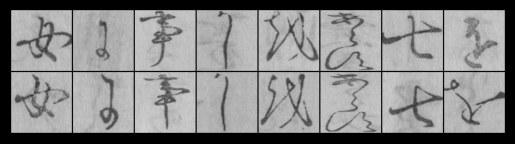

[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [24]:
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [25]:
images_1, images_2, targets = example_batch[0], example_batch[1], example_batch[2]
images_1, images_2, targets = (
    images_1.to(device),
    images_2.to(device),
    targets.to(device),
)
outputs = model(images_1, images_2)
pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
correct += pred.eq(targets.view_as(pred)).sum().item()